In [1]:
import cv2
import numpy as np
import glob
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

In [2]:
# TODO: store the images as matrices or tensors as they take forever to load.
path = "/kaggle/input/deepglobe-land-cover-classification-dataset/"

input_shape = (512, 512, 3)
out_shape = (512, 512, 3)
img_shape = (2448, 2448, 3)

In [3]:
def preprocess_img(img, shape):
    
    image = cv2.imread(img)
    assert image is not None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    out = np.array(cv2.resize(image, shape, interpolation = cv2.INTER_LINEAR),
                   dtype = np.uint8)
    return out
    
def preprocess_mask(img, shape):
    
    mask = np.array(np.round(preprocess_img(img, shape) / 255.0), dtype = np.uint8)
    mask_refined = 4 * mask[:,:,0] + 2 * mask[:,:,1] + mask[:,:,2]
    mask_refined = mask_refined * (mask_refined != 7) + 4 * (mask_refined == 7)
    
    return mask_refined

def get_dataset(path):
    
    mask_dirs = sorted(glob.glob(os.path.join(path,"*_mask.png")))
    sat_dirs = [d.replace("_mask.png", "_sat.jpg") for d in mask_dirs]
    
    X = tf.convert_to_tensor([preprocess_img(file, input_shape[:2]) for file in sat_dirs], dtype = tf.float16)
    y = tf.convert_to_tensor([preprocess_mask(file, out_shape[:2]) for file in mask_dirs], dtype = tf.uint8)
    
    #np.save("X_train.np",X.numpy())
    #np.save("y_train.np",y.numpy())
    
    return X, y

In [4]:
X_train, y_train = get_dataset(os.path.join(path, "train"))
#X_val, y_val = get_dataset(os.path.join(path, "valid"))
#X_test, y_test = get_dataset(os.path.join(path, "test"))

In [5]:
class ConvBlock(tf.keras.Model):
    
    def __init__(self, n_filters, filter_size):
        super().__init__()
        self.cn1 = tfl.Conv2D(n_filters, filter_size,
                            padding = "same")
        self.cn2 = tfl.Conv2D(n_filters, filter_size,
                            padding = "same")
        self.relu1 = tfl.ReLU()
        self.relu2 = tfl.ReLU()
        
    def call(self, x):
        
        x = self.relu1(self.cn1(x))
        x = self.relu2(self.cn2(x))
        
        return x

In [6]:
class UNetConv(ConvBlock):
    def __init__(self, n_filters, filter_size, pool_stride):
        super().__init__(n_filters, filter_size)
        self.pool = tfl.MaxPooling2D(pool_stride)

    def call(self, x):
        x = self.relu1(self.cn1(x))
        x = self.relu2(self.cn2(x))
        return x, self.pool(x)
        
    
class UNetTConv(ConvBlock):
    def __init__(self, filters, filter_size, tfilters, tfilter_size):
        super().__init__(filters, filter_size)
        self.dcn = tfl.Conv2DTranspose(tfilters, tfilter_size, tfilter_size, padding = "same")

    def call(self, x):
        x = self.relu1(self.cn1(x))
        x = self.relu2(self.cn2(x))
        return self.dcn(x)

In [7]:
n_blocks = 4
log_conv_filters = 6
n_classes = 7
filter_size = 3
tfilter_size = 2

In [8]:
class UNET(tf.keras.Model):
    
    def __init__(self, blocks):
        super().__init__()
        
        self.convs = [UNetConv(int(2**(log_conv_filters+i)), filter_size, 2) for i in range(blocks)]
        self.tconvs = [UNetTConv(int(2**(log_conv_filters + blocks -i)), filter_size,\
                int(2**(log_conv_filters + blocks -i)), tfilter_size) for i in range(blocks)]

        self.convf = ConvBlock(int(2**(log_conv_filters)), filter_size)
        self.conv1x1 =  tfl.Conv2D(n_classes, 1, padding = "same")
        self.softmax = tfl.Softmax(axis = -1)
    
    def call(self, x):
        xs = []
        for conv in self.convs:
            skip, x = conv(x)
            xs.append(skip)

        skip = None
        for tconv in self.tconvs:
            x = x if skip is None else tf.concat([skip, x], axis = -1)
            x = tconv(x)
            skip = xs.pop()
            
        x = self.convf(tf.concat([skip, x], axis = -1))
        x = self.softmax(self.conv1x1(x))
        
        return x

In [9]:
inputs = tf.keras.Input(input_shape)
model = UNET(n_blocks)
model(inputs)

<KerasTensor shape=(None, 512, 512, 7), dtype=float32, sparse=False, name=keras_tensor_15>

In [10]:
model.build(input_shape=(None, ) + input_shape)
model.summary()

Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ u_net_conv (UNetConv)           │ ?                      │        38,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_conv_1 (UNetConv)         │ ?                      │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_conv_2 (UNetConv)         │ ?                      │       885,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_conv_3 (UNetConv)         │ ?                      │     3,539,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_t_conv (UNetTConv)        │ ?                      │    18,353,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_t_conv_1 (UNetTConv)      │ ?                      │    10,487,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_t_conv_2 (UNetTConv)      │ ?                      │     2,622,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_t_conv_3 (UNetTConv)      │ ?                      │       655,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block (ConvBlock)          │ ?                      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ ?                      │           455 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,951,815 (140.96 MB)

 Trainable params: 36,951,815 (140.96 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
f1 = tf.keras.metrics.F1Score(average = "weighted")
def f1_score_images(y_true, y_pred):
    y_true_flat = tf.one_hot(tf.reshape(y_true,(-1,)), n_classes)
    y_pred_flat = tf.reshape(y_pred, (-1, n_classes))
    return f1(y_true_flat, y_pred_flat)

In [12]:
lr = 3e-4
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False)
optimizer = tf.keras.optimizers.AdamW(lr)
model.compile(loss = loss_fn, optimizer = optimizer, metrics = [f1_score_images])

In [13]:
def to_img(y):
    
    out = np.zeros(y.shape[:2] + (3,))
    
    out[:, :, 0] = (y // 4) * 255
    out[:, :, 1] = ((y % 4) // 2) * 255
    out[:, :, 2] = (y % 2) * 255

    return out

In [14]:
EPOCHS = 50
history = model.fit(X_train, y_train, epochs = EPOCHS, batch_size = 2, validation_split = 0.2)

Epoch 1/50


I0000 00:00:1765469010.785059      69 service.cc:145] XLA service 0x7838000018a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765469010.785169      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765469038.317084      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - f1_score_images: 0.3605 - loss: 1.9771

W0000 00:00:1765469116.611226      69 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1765469123.714028      68 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


321/321 ━━━━━━━━━━━━━━━━━━━━ 124s 285ms/step - f1_score_images: 0.3607 - loss: 1.9756 - val_f1_score_images: 0.4622 - val_loss: 1.2819
Epoch 2/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 84s 262ms/step - f1_score_images: 0.4674 - loss: 1.2538 - val_f1_score_images: 0.4809 - val_loss: 1.1984
Epoch 3/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 84s 262ms/step - f1_score_images: 0.4837 - loss: 1.1982 - val_f1_score_images: 0.4957 - val_loss: 1.1024
Epoch 4/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 84s 262ms/step - f1_score_images: 0.4987 - loss: 1.2134 - val_f1_score_images: 0.5012 - val_loss: 1.2112
Epoch 5/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 84s 261ms/step - f1_score_images: 0.4996 - loss: 1.2503 - val_f1_score_images: 0.5014 - val_loss: 1.0404
Epoch 6/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 84s 261ms/step - f1_score_images: 0.5050 - loss: 1.0770 - val_f1_score_images: 0.5106 - val_loss: 1.0592
Epoch 7/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 84s 261ms/step - f1_score_images: 0.5135 - loss: 1.0729 - val_f1_score_images: 0.5213 - val_loss: 0.

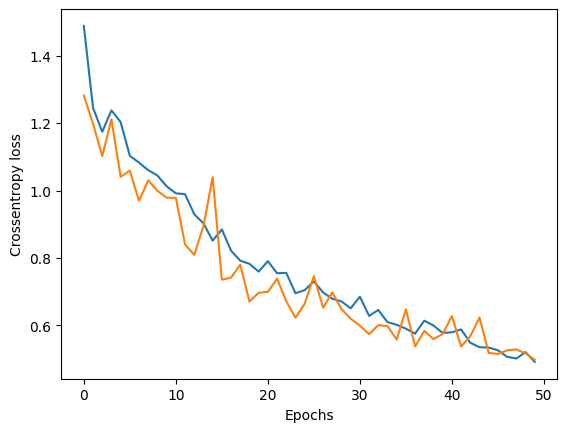

In [15]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Crossentropy loss")
plt.show()

In [16]:
def predict_mask(X_target):
    if len(X_target.shape) == 3:
        # Add batch dimension
        X_target = tf.reshape(X_target, (1,) + X_target.shape)
        
    y_pred = tf.argmax(model(X_target), axis = -1)[0]
    
    return y_pred

In [17]:
import seaborn as sns

def confusion_matrix_show(cm):
    class_labels = list(range(8))
    sns.heatmap(cm, 
                annot=True,
                fmt='g', 
                cmap='Blues',
                xticklabels=class_labels, 
                yticklabels=class_labels)
    
    plt.ylabel('Actual', fontsize=13)
    plt.title('Confusion Matrix', fontsize=17, pad=20)
    plt.gca().xaxis.set_label_position('top') 
    plt.xlabel('Prediction', fontsize=13)
    plt.gca().xaxis.tick_top()
    
    plt.gca().figure.subplots_adjust(bottom=0.2)
    plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
    plt.show()

In [18]:
def Visualize_output(X_target, y_target):
    y_pred = predict_mask(X_target)
    img_pred = to_img(y_pred)
    img_real = to_img(y_target)

    y_target_flat = tf.reshape(y_target,-1)
    y_pred_flat = tf.reshape(y_pred, -1)
    cm = confusion_matrix(y_target_flat, y_pred_flat, labels = np.arange(n_classes))
    confusion_matrix_show(cm)
    print(f"F1 Score: {f1(y_target_flat, y_pred_flat)}")
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot first image
    axes[0].imshow(img_pred, interpolation = 'nearest')
    axes[0].axis('off')
    axes[0].set_title("Predicted mask:")
    
    # Plot second image
    axes[1].imshow(img_real, interpolation = 'nearest')
    axes[1].axis('off')
    axes[1].set_title("Real mask:")
    
    # Display the images
    plt.tight_layout()
    plt.show()

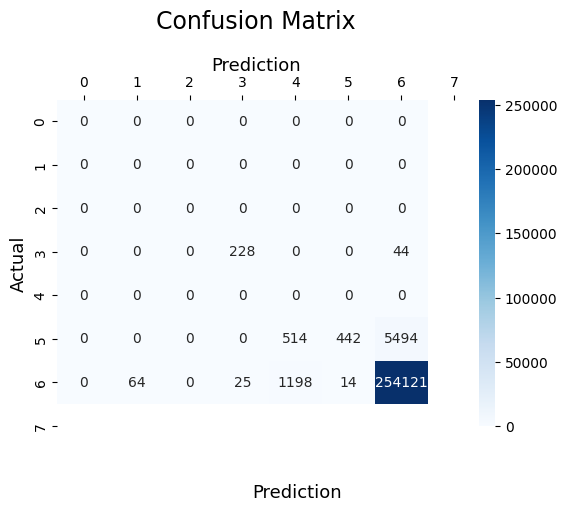

F1 Score: 0.7062073945999146


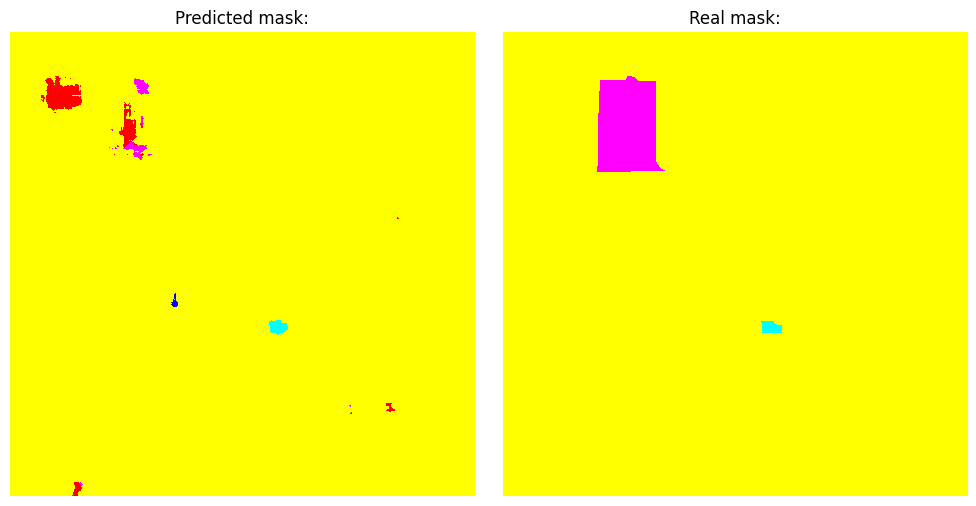

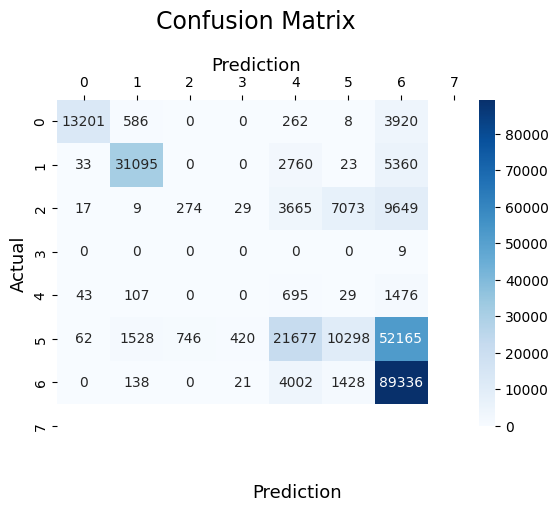

F1 Score: 0.7065238952636719


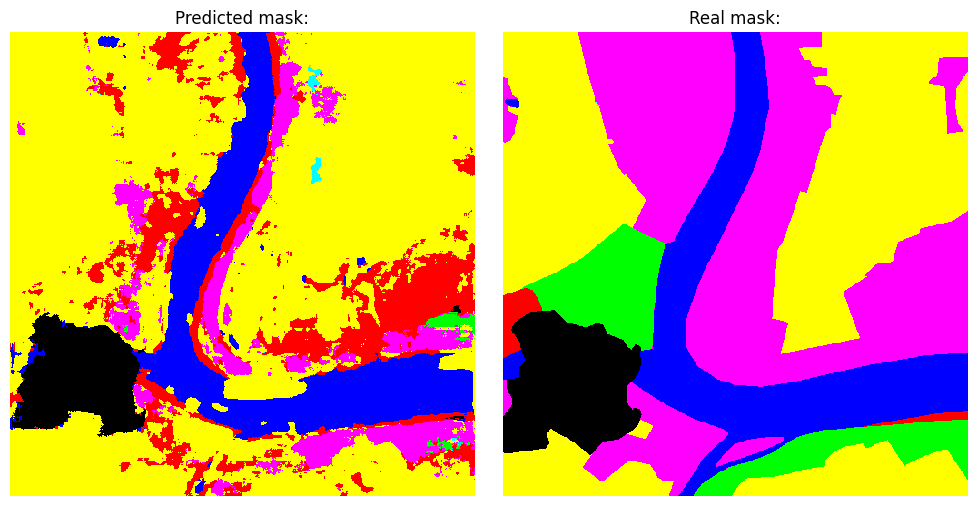

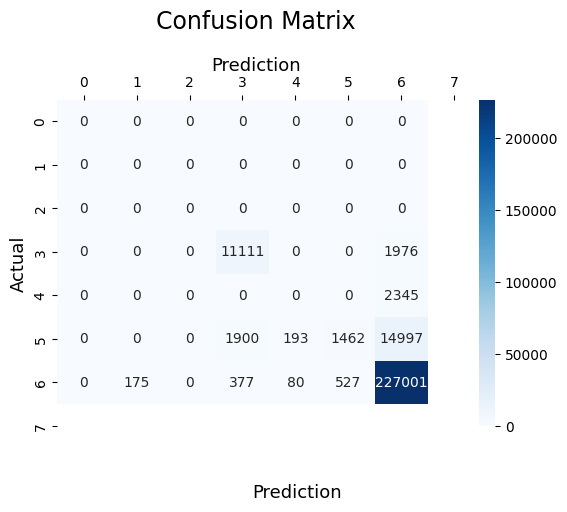

F1 Score: 0.7072166204452515


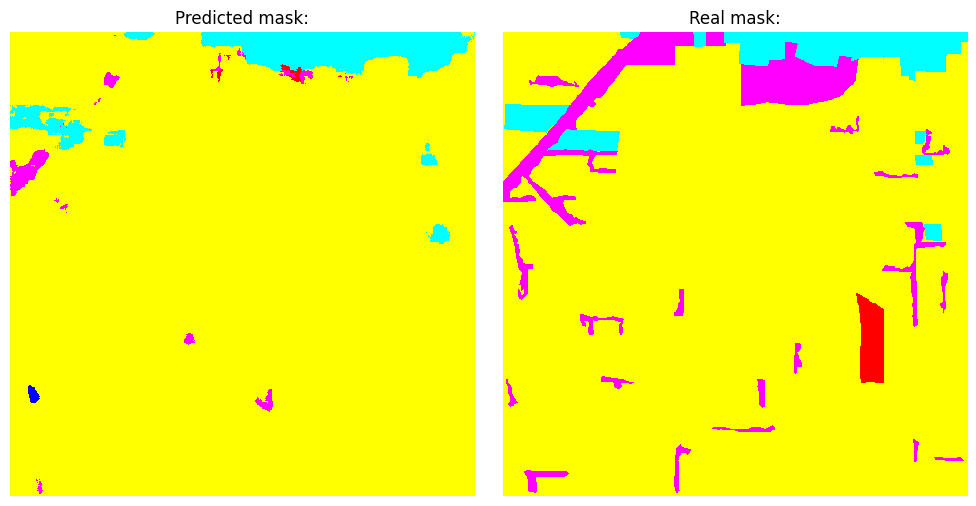

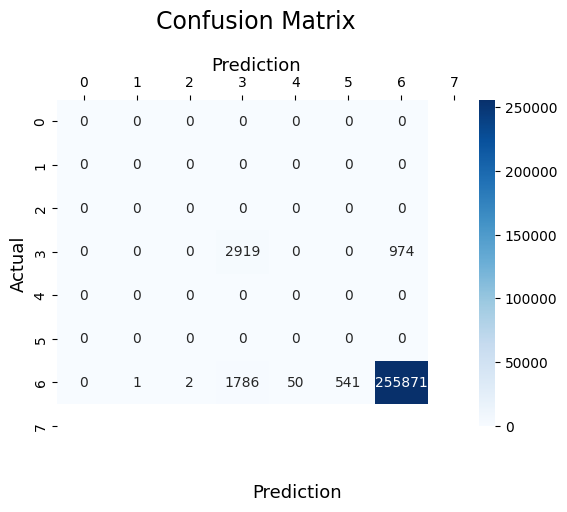

F1 Score: 0.7079639434814453


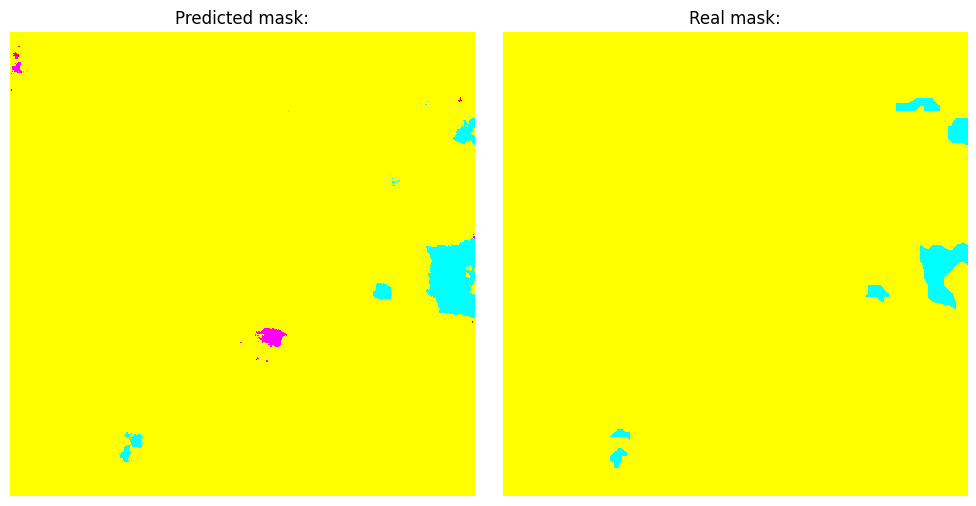

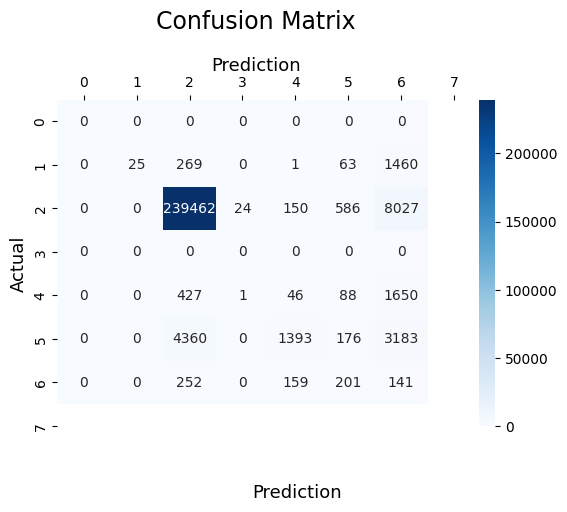

F1 Score: 0.7078243494033813


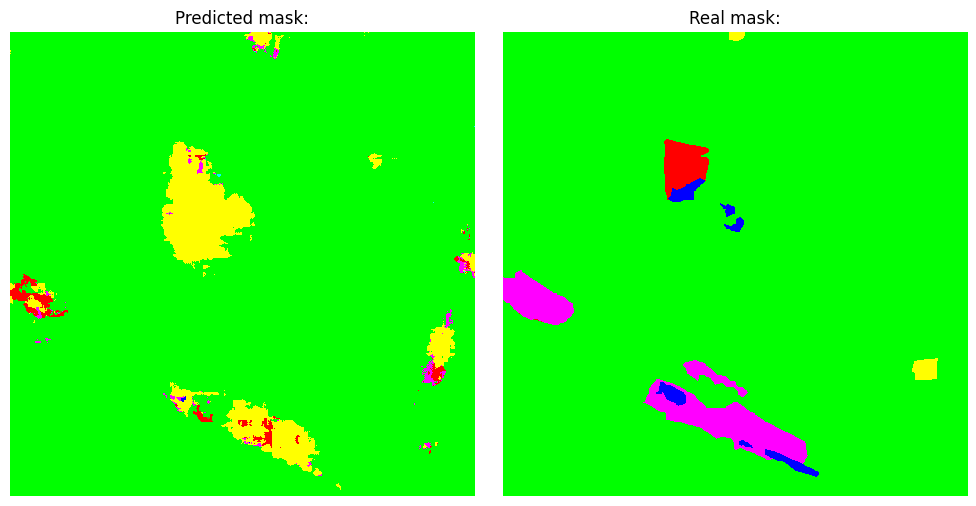

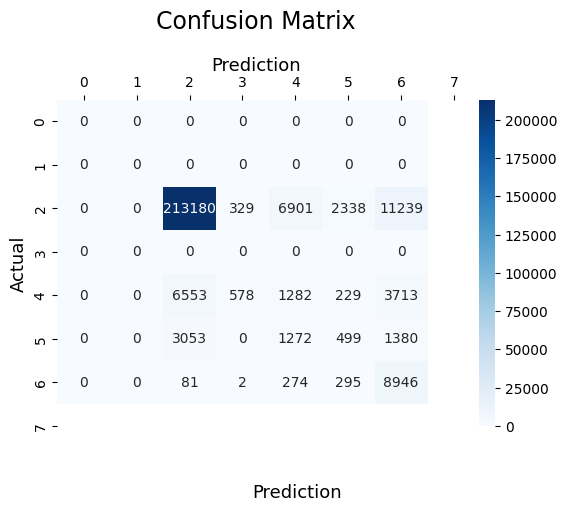

F1 Score: 0.7077147960662842


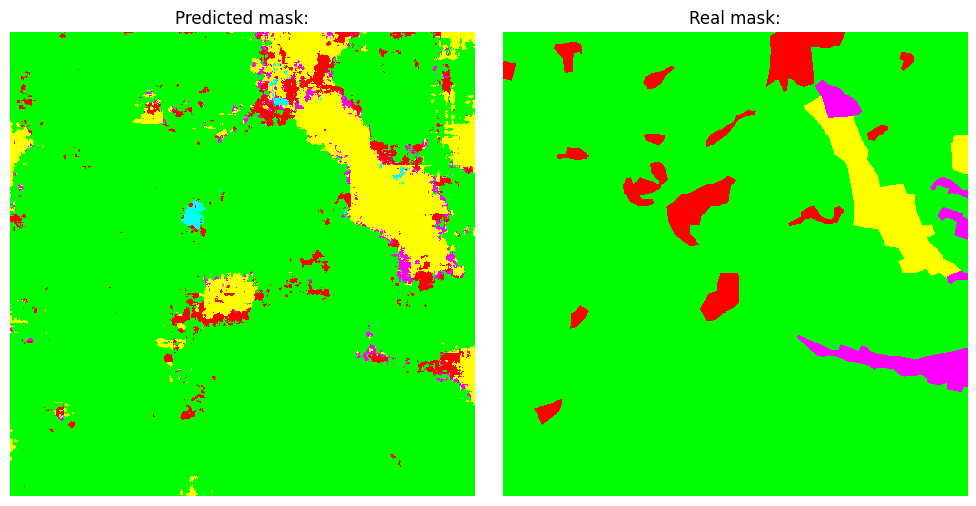

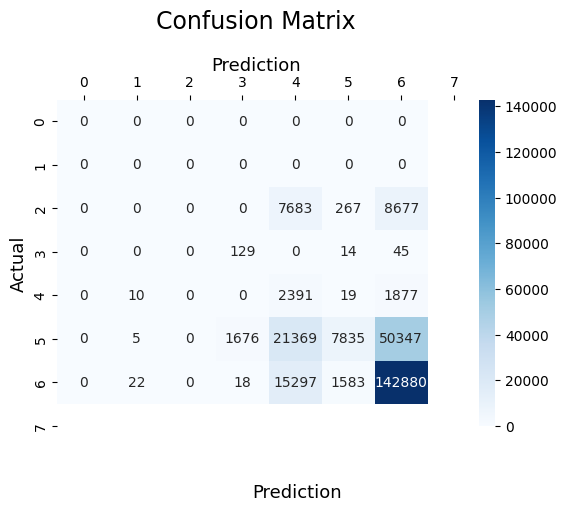

F1 Score: 0.7081820368766785


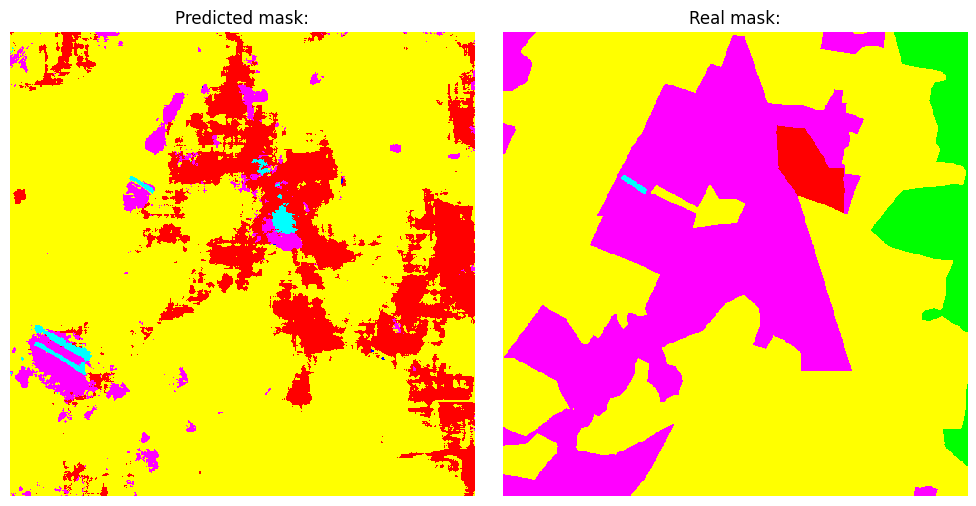

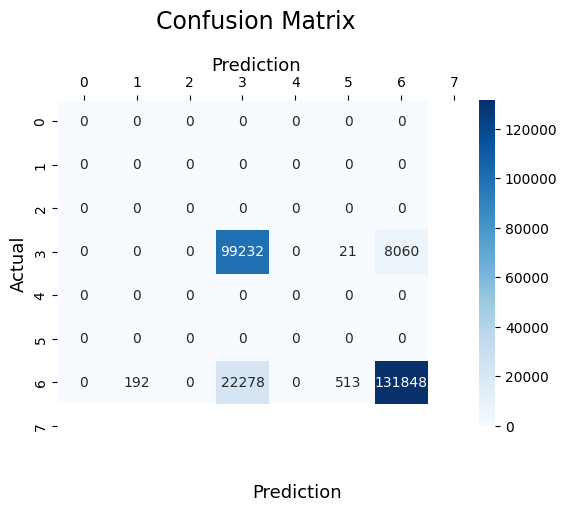

F1 Score: 0.7084485292434692


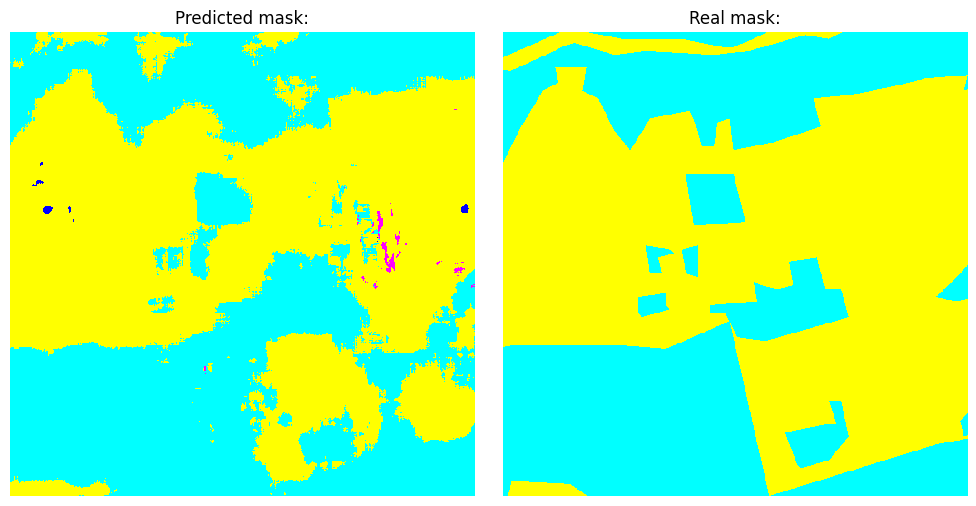

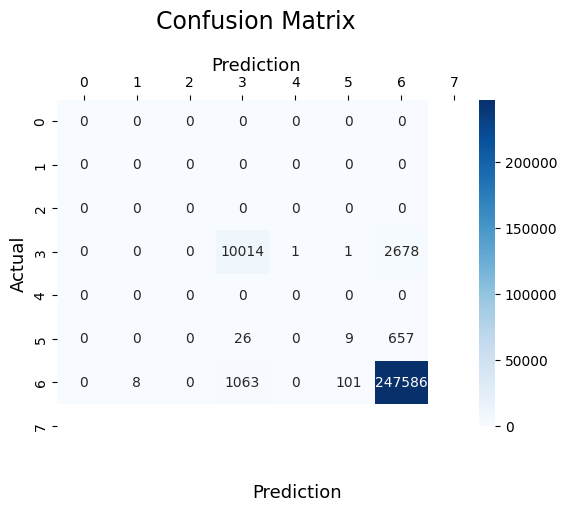

F1 Score: 0.7091723680496216


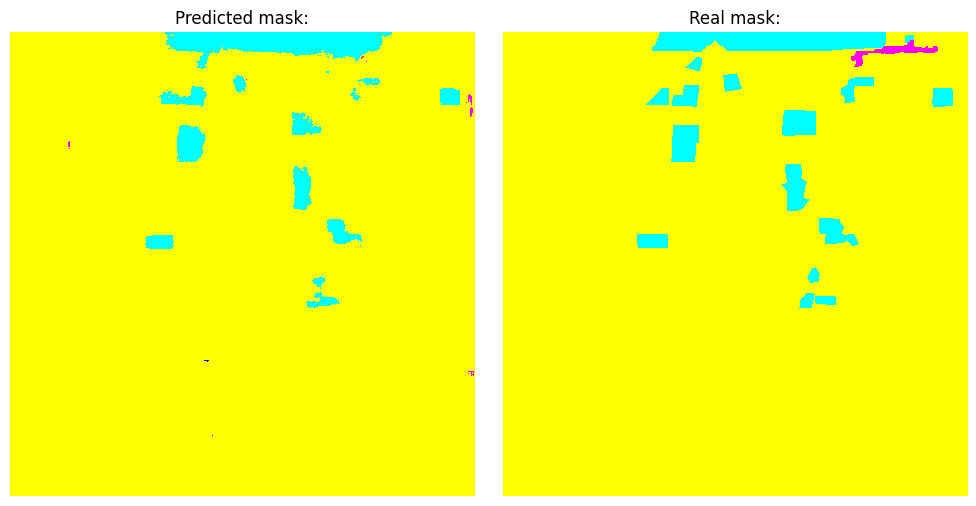

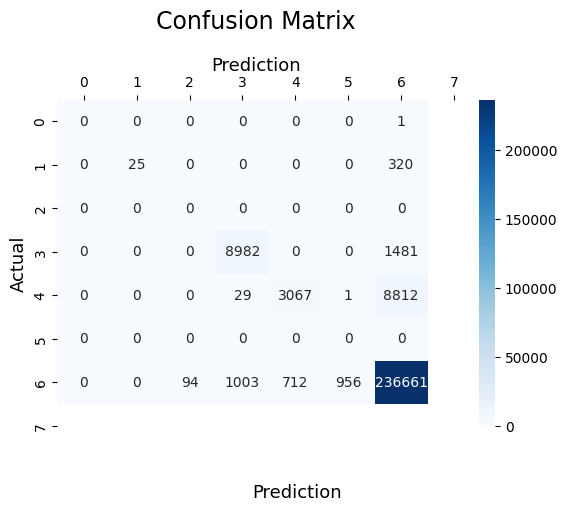

F1 Score: 0.7098710536956787


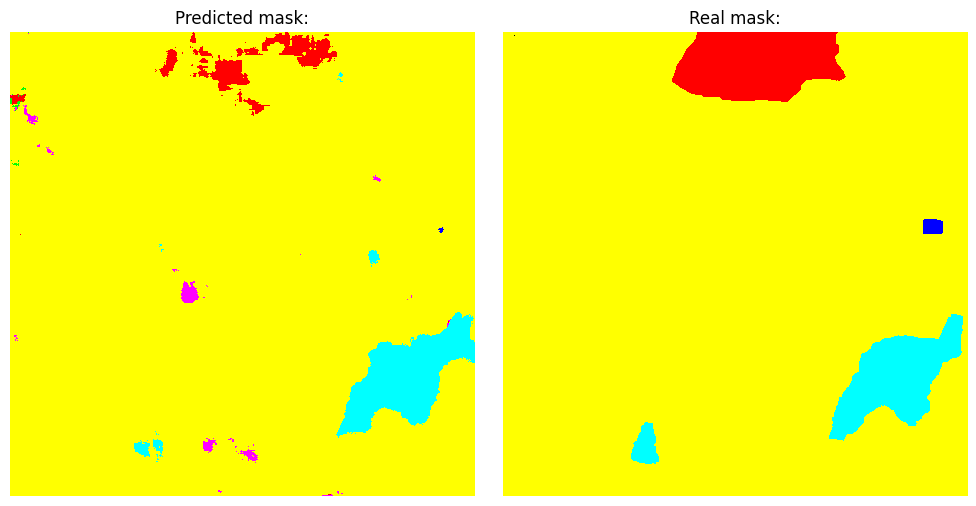

In [19]:
random_indices = np.random.randint(0, X_train.shape[0], 10)
for i in random_indices:
    Visualize_output(X_train[i], y_train[i])